Обучить СНС с помощью Transfer Learning на датасете Food-101
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
Библиотеки: [Python, Tensorflow]



In [2]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета

In [78]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:50%]', 'train[50%:]'],
)

## Визуализация датасета food101

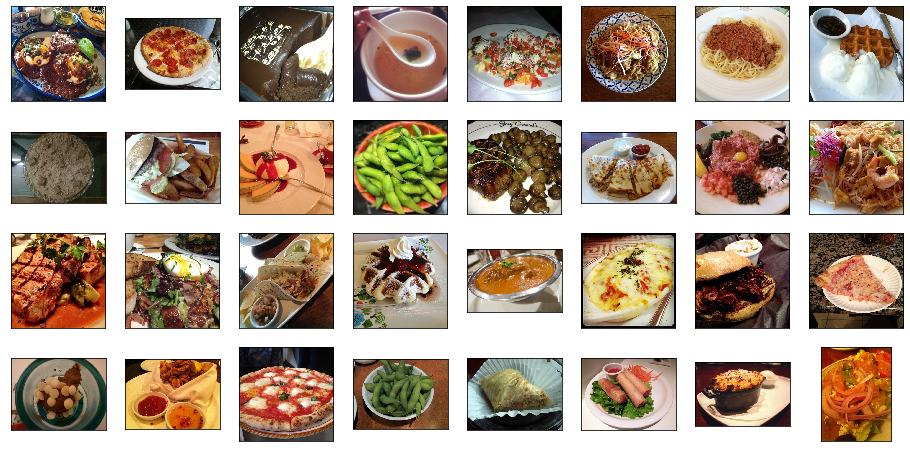

In [79]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание пайплайна данных

In [87]:
INP_SIZE = 160
NUM_EPOCHS = 5
BATCH_SIZE = 64

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

def augmentation(img,label):
    img,label = convert(img, label)
    tf.image.random_contrast(x, 0.4, 0.7)
    img = tf.image.random_flip_left_right(img)           
                 

    return img,label



In [81]:
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_augm = train_ds.map(augment)
train_ds = train_ds.concatenate(train_augm)

train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)


# Подготовка модели CNN

In [82]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(101, activation='softmax')
])




## Подготовка к обучению

In [83]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
'''
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)'''

"\ntensorboard_callback = tf.keras.callbacks.TensorBoard(\n    log_dir='logs/'+EXP_NAME, \n    write_graph=False, update_freq=100, profile_batch=0)"

In [84]:
## Model Summary

In [85]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 101)               129381    
Total params: 2,387,365
Trainable params: 2,353,253
Non-trainable params: 34,112
_________________________________________________________________


## Обучение модели

In [88]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds)
    #callbacks=[tensorboard_callback])


Epoch 1/5
1183/1183 [==============================] - 8450s 7s/step - loss: 2.9878 - accuracy: 0.2950 - val_loss: 5.9709 - val_accuracy: 0.0755
Epoch 2/5
1183/1183 [==============================] - 8395s 7s/step - loss: 2.0229 - accuracy: 0.4887 - val_loss: 7.7196 - val_accuracy: 0.0282
Epoch 3/5
1183/1183 [==============================] - 8385s 7s/step - loss: 1.6007 - accuracy: 0.5814 - val_loss: 9.5648 - val_accuracy: 0.0136
Epoch 4/5
1183/1183 [==============================] - 8391s 7s/step - loss: 1.3030 - accuracy: 0.6518 - val_loss: 9.2857 - val_accuracy: 0.0128
Epoch 5/5
1183/1183 [==============================] - 8360s 7s/step - loss: 1.0752 - accuracy: 0.7077 - val_loss: 11.0950 - val_accuracy: 0.0107
Wall time: 11h 40min 21s


## Оценка качества модели

In [89]:
%%time

model.evaluate(test_ds)

295/295 [==============================] - 445s 2s/step - loss: 11.0952 - accuracy: 0.0106
Wall time: 7min 27s


[11.09518051147461, 0.010646186769008636]

## Запуск предсказания на нашем изображении

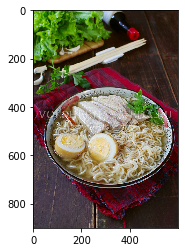

In [91]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

#https://volshebnaya-eda.ru/wp-content/uploads/2017/08/sup-ramen-9.jpg
img = imageio.imread('sup-ramen-9.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)




In [158]:
maxElement = np.amax(pred.numpy()[0])
print(maxElement)
result = sorted(np.where(pred.numpy()[0] >0.08))
for i in range(len(result[0])):
    print('Prediction: {}'.format(ds_info.features['label'].int2str(result[0][i])), 'Probability {}'.format(float('%.2f' % (pred.numpy()[0][result[0][i]]))))


0.37344816
Prediction: macarons Probability 0.37
Prediction: panna_cotta Probability 0.08
Prediction: red_velvet_cake Probability 0.14
Prediction: tiramisu Probability 0.13


Итоги:

Следовало взять больше эпох, но слишком долгие расчеты.

Суп рамен был в списке, но он не оказался среди вероятного списка, правда наиболее вероятные макароны и красный  пирог объяснимы
